In [3]:
import numpy as np
import datetime, time, json
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, History
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
import pandas as pd

In [27]:
quora_corpus = np.load("/Users/zhang/MscProject_tweak2vec/corpus/quora_corpus_int5.npy")
labels = np.load("/Users/zhang/MscProject_tweak2vec/corpus/quora_labels.npy")

w2v_embedding = {}


# w2v_embedding['reg_5m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_pivotsfull_alpha10_5m.npy")
# w2v_embedding['reg_3m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_pivotsfull_alpha10_3m.npy")
# w2v_embedding['reg_1m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_pivotsfull_alpha10_1m.npy")
# w2v_embedding['reg_05m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_pivotsfull_alpha10_05m.npy")
# w2v_embedding['reg_01m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_pivotsfull_alpha10_01m.npy")
# w2v_embedding['reg_005m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_pivotsfull_alpha10_005m.npy")
# w2v_embedding['reg_001m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_pivotsfull_alpha10_001m.npy")

# w2v_embedding['cat_reg_5m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_cat_reg_5m.npy")
# w2v_embedding['cat_reg_3m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_cat_reg_3m.npy")
# w2v_embedding['cat_reg_1m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_cat_reg_1m.npy")
# w2v_embedding['cat_reg_05m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_cat_reg_05m.npy")
# w2v_embedding['cat_reg_01m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_cat_reg_01m.npy")
# w2v_embedding['cat_reg_005m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_cat_reg_005m.npy")
# w2v_embedding['cat_reg_001m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_cat_reg_001m.npy")

w2v_embedding['ret_5m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_retrain_5m.npy")
w2v_embedding['ret_3m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_retrain_3m.npy")
w2v_embedding['ret_1m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_retrain_1m.npy")
w2v_embedding['ret_05m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_retrain_05m.npy")
w2v_embedding['ret_01m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_retrain_01m.npy")
w2v_embedding['ret_005m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_retrain_005m.npy")
w2v_embedding['ret_001m'] = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_retrain_001m.npy")


#w2v_google_50d = np.load("/Users/zhang/MscProject_tweak2vec/word2vecModel/quora/tokens/w2v_quoragoogle_50d.npy")
#w2v_concat = np.concatenate([w2v_google_50d, w2v_pivots100_50d], axis=1)
#w2v_avg = (w2v_google_50d + w2v_quora_50d)/2  

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
w2v_cat_reg = {}
for reg in w2v_embedding.keys():
    name = 'cat_'+reg
    w2v_concat = np.concatenate([w2v_google_50d, w2v_embedding[reg]], axis=1)
    w2v_concat = pca.fit_transform(w2v_concat)
    np.save('w2v_cat_'+reg+'.npy',w2v_concat)
    print(w2v_concat.shape)
    w2v_cat_reg[name] = w2v_concat

(30300, 50)
(30300, 50)
(30300, 50)
(30300, 50)
(30300, 50)
(30300, 50)
(30300, 50)


In [5]:
# separate question1 and question2
question1 = []
question2 = []
for n in range(int(len(quora_corpus)/2)):
    question1.append(quora_corpus[2*n])
    question2.append(quora_corpus[2*n+1])
    
q1_data = pad_sequences(question1, maxlen=25)
q2_data = pad_sequences(question2, maxlen=25)

In [5]:
l = 0
l_avg = []
for i in range(len(quora_corpus)):
    if len(quora_corpus[i]) > l:
        l = len(quora_corpus[i])
    l_avg.append(len(quora_corpus[i]))
print('max length:{0}, average length:{1}'.format(l,np.mean(np.array(l_avg))))

max length:190, average length:8.62675648734686


In [28]:
# hyperparameter setup
max_sentence_len = 25
embed_dim = 50
dropout_rate = 0.1
vocab_size = len(w2v_embedding['ret_5m'])

In [9]:
# split cross validation set and test set
questions = np.stack((q1_data, q2_data), axis=1)
X_train, X_test, y_train, y_test = train_test_split(questions, labels, test_size=0.1, random_state=2018)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

### define the model

In [23]:
def Max_BoE(word_embedding):

    question1 = Input(shape=(max_sentence_len,))
    question2 = Input(shape=(max_sentence_len,))



    q1 = Embedding(  input_dim=vocab_size, 
                     output_dim=embed_dim, 
                     weights=[word_embedding], 
                     input_length=max_sentence_len, 
                     trainable=False)(question1)
    q1 = TimeDistributed(Dense(embed_dim, activation='relu'))(q1)
    q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(embed_dim, ))(q1)

    q2 = Embedding(  input_dim=vocab_size, 
                     output_dim=embed_dim, 
                     weights=[word_embedding], 
                     input_length=max_sentence_len, 
                     trainable=False)(question2)
    q2 = TimeDistributed(Dense(embed_dim, activation='relu'))(q2)
    q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(embed_dim, ))(q2)

    merged = concatenate([q1,q2])
    merged = Dense(200, activation='relu')(merged)
    merged = Dropout(dropout_rate)(merged)
    merged = BatchNormalization()(merged)
    merged = Dense(200, activation='relu')(merged)
    merged = Dropout(dropout_rate)(merged)
    merged = BatchNormalization()(merged)
    merged = Dense(200, activation='relu')(merged)
    merged = Dropout(dropout_rate)(merged)
    merged = BatchNormalization()(merged)
    merged = Dense(200, activation='relu')(merged)
    merged = Dropout(dropout_rate)(merged)
    merged = BatchNormalization()(merged)

    is_duplicate = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[question1,question2], outputs=is_duplicate)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


### train the model

In [24]:
n_epoch = 50
val_split = 0.1
batch_size = 32

In [29]:
save_data = {}
for embed_name in w2v_embedding.keys():
    current_embed = w2v_embedding[embed_name]
    model = Max_BoE(current_embed)
    MODEL_WEIGHTS_FILE = '/Users/zhang/MscProject_tweak2vec/Max_BOE_weights/'+embed_name+'_weights.h5'
    print('current embedding: ',embed_name)
    print("Starting training at", datetime.datetime.now())
    t0 = time.time()
    callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
    model_history = model.fit([Q1_train, Q2_train],
                        y_train,
                        epochs=n_epoch,
                        validation_split=val_split,
                        verbose=1,
                        batch_size=batch_size,
                        callbacks=callbacks)
    save_data[embed_name] = model_history.history
    t1 = time.time()
    print("Training ended at", datetime.datetime.now())
    print("Minutes elapsed: %f" % ((t1 - t0) / 60.))
    print("-------------------------------------------------------------------------") 
    print("-------------------------------------------------------------------------")

current embedding:  ret_5m
Starting training at 2018-08-01 02:49:42.205811
Train on 327472 samples, validate on 36386 samples
Epoch 1/50
327472/327472 [==============================] - 88s 268us/step - loss: 0.5439 - acc: 0.7249 - val_loss: 0.4918 - val_acc: 0.7588
Epoch 2/50
327472/327472 [==============================] - 74s 226us/step - loss: 0.4977 - acc: 0.7537 - val_loss: 0.4704 - val_acc: 0.7711
Epoch 3/50
327472/327472 [==============================] - 74s 225us/step - loss: 0.4806 - acc: 0.7630 - val_loss: 0.4632 - val_acc: 0.7756
Epoch 4/50
327472/327472 [==============================] - 74s 226us/step - loss: 0.4707 - acc: 0.7673 - val_loss: 0.4558 - val_acc: 0.7777
Epoch 5/50
327472/327472 [==============================] - 74s 227us/step - loss: 0.4649 - acc: 0.7721 - val_loss: 0.4487 - val_acc: 0.7819
Epoch 6/50
327472/327472 [==============================] - 76s 231us/step - loss: 0.4599 - acc: 0.7743 - val_loss: 0.4468 - val_acc: 0.7845
Epoch 7/50
327472/327472 [==

327472/327472 [==============================] - 71s 216us/step - loss: 0.4677 - acc: 0.7703 - val_loss: 0.4507 - val_acc: 0.7810
Epoch 6/50
327472/327472 [==============================] - 72s 220us/step - loss: 0.4623 - acc: 0.7740 - val_loss: 0.4473 - val_acc: 0.7823
Epoch 7/50
327472/327472 [==============================] - 71s 215us/step - loss: 0.4571 - acc: 0.7770 - val_loss: 0.4455 - val_acc: 0.7792
Epoch 8/50
327472/327472 [==============================] - 71s 216us/step - loss: 0.4537 - acc: 0.7791 - val_loss: 0.4446 - val_acc: 0.7827
Epoch 9/50
327472/327472 [==============================] - 72s 219us/step - loss: 0.4498 - acc: 0.7817 - val_loss: 0.4485 - val_acc: 0.7837
Epoch 10/50
327472/327472 [==============================] - 70s 215us/step - loss: 0.4468 - acc: 0.7830 - val_loss: 0.4394 - val_acc: 0.7847
Epoch 11/50
327472/327472 [==============================] - 71s 218us/step - loss: 0.4443 - acc: 0.7848 - val_loss: 0.4397 - val_acc: 0.7857
Epoch 12/50
327472/327

327472/327472 [==============================] - 73s 224us/step - loss: 0.4558 - acc: 0.7774 - val_loss: 0.4488 - val_acc: 0.7816
Epoch 11/50
327472/327472 [==============================] - 74s 226us/step - loss: 0.4528 - acc: 0.7797 - val_loss: 0.4449 - val_acc: 0.7841
Epoch 12/50
327472/327472 [==============================] - 73s 224us/step - loss: 0.4492 - acc: 0.7810 - val_loss: 0.4463 - val_acc: 0.7835
Epoch 13/50
327472/327472 [==============================] - 74s 225us/step - loss: 0.4478 - acc: 0.7820 - val_loss: 0.4438 - val_acc: 0.7842
Epoch 14/50
327472/327472 [==============================] - 74s 225us/step - loss: 0.4462 - acc: 0.7827 - val_loss: 0.4436 - val_acc: 0.7821
Epoch 15/50
327472/327472 [==============================] - 73s 224us/step - loss: 0.4443 - acc: 0.7842 - val_loss: 0.4406 - val_acc: 0.7881
Epoch 16/50
327472/327472 [==============================] - 74s 226us/step - loss: 0.4427 - acc: 0.7856 - val_loss: 0.4471 - val_acc: 0.7835
Epoch 17/50
327472

327472/327472 [==============================] - 76s 231us/step - loss: 0.4531 - acc: 0.7787 - val_loss: 0.4515 - val_acc: 0.7796
Epoch 16/50
327472/327472 [==============================] - 76s 233us/step - loss: 0.4500 - acc: 0.7804 - val_loss: 0.4495 - val_acc: 0.7810
Epoch 17/50
327472/327472 [==============================] - 76s 232us/step - loss: 0.4487 - acc: 0.7812 - val_loss: 0.4479 - val_acc: 0.7807
Epoch 18/50
327472/327472 [==============================] - 76s 232us/step - loss: 0.4479 - acc: 0.7815 - val_loss: 0.4459 - val_acc: 0.7826
Epoch 19/50
327472/327472 [==============================] - 76s 232us/step - loss: 0.4464 - acc: 0.7822 - val_loss: 0.4496 - val_acc: 0.7795
Epoch 20/50
327472/327472 [==============================] - 76s 231us/step - loss: 0.4449 - acc: 0.7835 - val_loss: 0.4516 - val_acc: 0.7774
Epoch 21/50
327472/327472 [==============================] - 76s 232us/step - loss: 0.4439 - acc: 0.7847 - val_loss: 0.4500 - val_acc: 0.7805
Epoch 22/50
327472

327472/327472 [==============================] - 78s 239us/step - loss: 0.4560 - acc: 0.7787 - val_loss: 0.4530 - val_acc: 0.7774
Epoch 21/50
327472/327472 [==============================] - 79s 241us/step - loss: 0.4545 - acc: 0.7791 - val_loss: 0.4550 - val_acc: 0.7772
Epoch 22/50
327472/327472 [==============================] - 78s 240us/step - loss: 0.4539 - acc: 0.7793 - val_loss: 0.4578 - val_acc: 0.7765
Epoch 23/50
327472/327472 [==============================] - 78s 240us/step - loss: 0.4533 - acc: 0.7807 - val_loss: 0.4552 - val_acc: 0.7772
Epoch 24/50
327472/327472 [==============================] - 79s 241us/step - loss: 0.4526 - acc: 0.7805 - val_loss: 0.4601 - val_acc: 0.7737
Epoch 25/50
327472/327472 [==============================] - 79s 241us/step - loss: 0.4508 - acc: 0.7809 - val_loss: 0.4511 - val_acc: 0.7776
Epoch 26/50
327472/327472 [==============================] - 79s 240us/step - loss: 0.4499 - acc: 0.7817 - val_loss: 0.4498 - val_acc: 0.7801
Epoch 27/50
327472

327472/327472 [==============================] - 81s 247us/step - loss: 0.4397 - acc: 0.7888 - val_loss: 0.4415 - val_acc: 0.7862
Epoch 26/50
327472/327472 [==============================] - 81s 247us/step - loss: 0.4390 - acc: 0.7899 - val_loss: 0.4455 - val_acc: 0.7814
Epoch 27/50
327472/327472 [==============================] - 81s 248us/step - loss: 0.4376 - acc: 0.7904 - val_loss: 0.4407 - val_acc: 0.7854
Epoch 28/50
327472/327472 [==============================] - 81s 247us/step - loss: 0.4368 - acc: 0.7911 - val_loss: 0.4434 - val_acc: 0.7856
Epoch 29/50
327472/327472 [==============================] - 81s 247us/step - loss: 0.4365 - acc: 0.7912 - val_loss: 0.4376 - val_acc: 0.7863
Epoch 30/50
327472/327472 [==============================] - 81s 246us/step - loss: 0.4345 - acc: 0.7916 - val_loss: 0.4404 - val_acc: 0.7877
Epoch 31/50
327472/327472 [==============================] - 81s 247us/step - loss: 0.4347 - acc: 0.7928 - val_loss: 0.4434 - val_acc: 0.7858
Epoch 32/50
327472

327472/327472 [==============================] - 82s 250us/step - loss: 0.4261 - acc: 0.7967 - val_loss: 0.4358 - val_acc: 0.7913
Epoch 31/50
327472/327472 [==============================] - 82s 252us/step - loss: 0.4250 - acc: 0.7970 - val_loss: 0.4342 - val_acc: 0.7912
Epoch 32/50
327472/327472 [==============================] - 82s 249us/step - loss: 0.4256 - acc: 0.7969 - val_loss: 0.4340 - val_acc: 0.7917
Epoch 33/50
327472/327472 [==============================] - 82s 250us/step - loss: 0.4251 - acc: 0.7972 - val_loss: 0.4354 - val_acc: 0.7912
Epoch 34/50
327472/327472 [==============================] - 82s 250us/step - loss: 0.4239 - acc: 0.7985 - val_loss: 0.4362 - val_acc: 0.7899
Epoch 35/50
327472/327472 [==============================] - 82s 252us/step - loss: 0.4233 - acc: 0.7988 - val_loss: 0.4384 - val_acc: 0.7913
Epoch 36/50
327472/327472 [==============================] - 82s 249us/step - loss: 0.4228 - acc: 0.7994 - val_loss: 0.4360 - val_acc: 0.7937
Epoch 37/50
327472

In [30]:
f = open('retrain_data.txt','w')
f.write(str(save_data))
f.close()

In [172]:
f = open('/Users/zhang/MscProject_tweak2vec/word2vecModel/quora_data/pivotsfull_alpha_tune_data.txt','r')
a = f.read()
adata = eval(a)
adata.keys()

dict_keys(['pivotsfull_alpha1_1m', 'pivotsfull_alpha10_1m', 'pivotsfull_alpha100_1m'])

In [178]:
f = open('/Users/zhang/MscProject_tweak2vec/word2vecModel/quora_data/pivotsfull_data.txt','r')
a = f.read()
fdata = eval(a)
fdata.keys()

dict_keys(['pivotsfull_5m', 'pivotsfull_3m', 'pivotsfull_1m', 'pivotsfull_05m', 'pivotsfull_01m', 'pivotsfull_005m', 'pivotsfull_001m'])

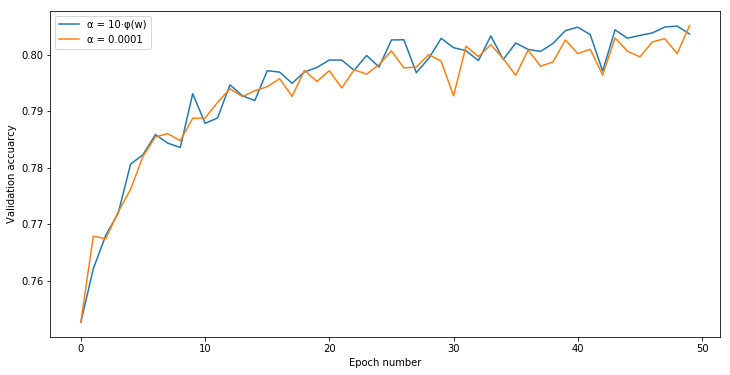

In [180]:
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(111)
model_num = range(50)

ax1.plot(model_num,adata['pivotsfull_alpha10_1m']['val_acc'], linestyle='-', label='α = 10·φ(w)')
ax1.plot(model_num,fdata['pivotsfull_1m']['val_acc'], linestyle='-', label='α = 0.0001')
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation accuarcy')
#plt.ylim(0.74,0.79)
plt.show()
fig.savefig('tune_lambda_in_alpha.pdf')

### Evaluate the model with best validation accuracy on the test partition

In [161]:
MODEL_WEIGHTS_FILE = '/Users/zhang/MscProject_tweak2vec/Max_BOE_weights/quora_5m_weights.h5'

model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
pred_y = model.predict([Q1_test, Q2_test], verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.4198, accuracy = 0.7981


In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 25, 50)       1515000     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 25, 50)       1515000     input_6[0][0]                    
__________________________________________________________________________________________________
time_distr